In [6]:
import pandas as pd 
from sklearn.externals import joblib
import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline 

In [7]:
df_week = pd.read_csv("http://www.football-data.co.uk/mmz4281/1617/I1.csv")

In [8]:
df_week[(df_week.HomeTeam=="Inter") | (df_week.AwayTeam=="Inter")].shape[0]

15

In [9]:
def get_teams(df):
    
    teams = []
    
    for i,cal in enumerate(df.iterrows()):
        teams.append(cal[1]["HomeTeam"])
        teams.append(cal[1]["AwayTeam"])

        if i == 9: 
            return teams


In [10]:
teams_1617 = get_teams(df_week)

print teams_1617

['Juventus', 'Fiorentina', 'Roma', 'Udinese', 'Atalanta', 'Lazio', 'Bologna', 'Crotone', 'Chievo', 'Inter', 'Empoli', 'Sampdoria', 'Genoa', 'Cagliari', 'Milan', 'Torino', 'Palermo', 'Sassuolo', 'Pescara', 'Napoli']


In [11]:
def build_features(df, teams):

    team_features = []
    
    for team in teams:
        #print team_a
        team_home = df[df['HomeTeam']==team]
        team_away = df[df['AwayTeam']==team]
        
        #shots made
        team_s    = team_away["AS"].sum()  + team_home["HS"].sum()
        #shots on-target made
        team_st   = team_away["AST"].sum() + team_home["HST"].sum()
        #shots conceded
        team_sc    = team_away["HS"].sum()  + team_home["AS"].sum()
        #shots on-target conceded
        team_stc   = team_away["HST"].sum() + team_home["AST"].sum()
        #corners awarded
        team_c    = team_away["AC"].sum()  + team_home["HC"].sum()
        #corners conceded
        team_cc    = team_away["HC"].sum()  + team_home["AC"].sum()

        team_features.append([team_s,team_sc,team_st,team_stc,team_c,team_cc])

    return team_features

In [12]:
def build_target(df, teams):

    team_target = []
    
    for team in teams:
        #print team_a
        t      = df[(df['HomeTeam']==team) | (df['AwayTeam']==team)]
        team_home = df[df['HomeTeam']==team]
        team_away = df[df['AwayTeam']==team]

        team_h_win = len(team_home[team_home['FTHG']>team_home['FTAG']])
        team_a_win = len(team_away[team_away['FTAG']>team_away['FTHG']])
        team_draw = len(t[t['FTAG']==t['FTHG']])

        team_points = 3*team_a_win + 3*team_h_win + team_draw
        team_target.append(team_points)

    return team_target


In [13]:
targ_1617 = build_target(df_week, teams_1617)
feat_1617 = build_features(df_week, teams_1617)

In [14]:
model_1 = joblib.load('../data/linreg_model.pkl')

pred_1617 = model_1.predict(feat_1617)

In [15]:
#print pred_1617
#print teams_1617
ranking  = []
realrank = []

for t,p,tg in zip(teams_1617,pred_1617,targ_1617):
    ranking.append((t, p, tg))
    
for t,p in zip(teams_1617,targ_1617):
    realrank.append((t, p))
    

In [16]:
ranking.sort(key=lambda x: x[2],reverse=True)
teams_pred_real = []

for t,p,tg in ranking:
    print t,'{:.1f}'.format(p),'{:.0f}'.format(tg), '{:.1f}'.format(tg-p)
    teams_pred_real.append((t,'{:.1f}'.format(p),'{:.1f}'.format(tg)))
    

Juventus 29.4 36 6.6
Roma 29.7 32 2.3
Milan 20.6 32 11.4
Atalanta 21.1 28 6.9
Lazio 24.1 28 3.9
Napoli 30.2 28 -2.2
Torino 26.2 25 -1.2
Fiorentina 24.4 23 -1.4
Sampdoria 23.5 22 -1.5
Inter 27.6 21 -6.6
Genoa 18.5 20 1.5
Cagliari 15.0 20 5.0
Chievo 16.2 19 2.8
Udinese 19.5 18 -1.5
Sassuolo 18.8 17 -1.8
Bologna 14.9 16 1.1
Empoli 12.9 10 -2.9
Pescara 18.8 8 -10.8
Crotone 11.6 6 -5.6
Palermo 11.8 6 -5.8


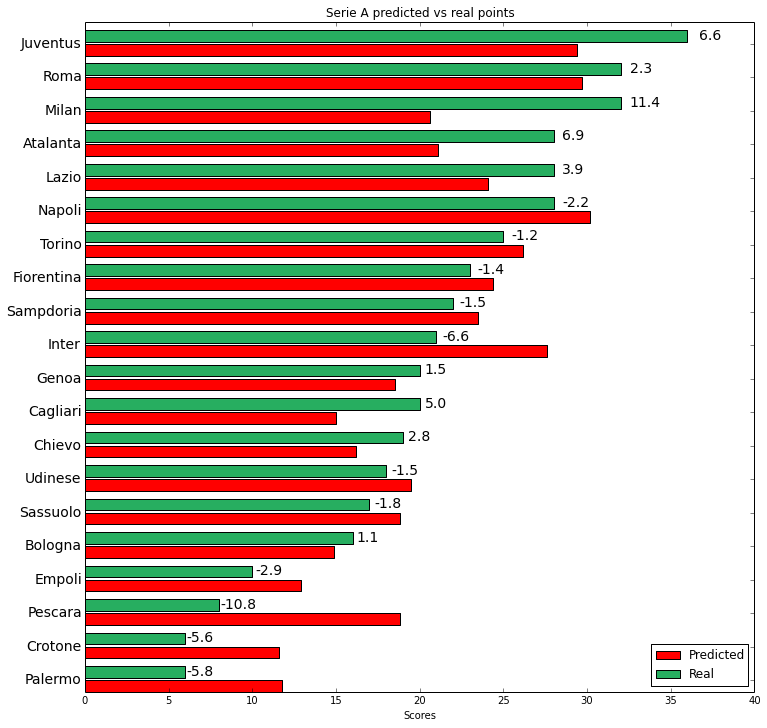

In [17]:
#!/usr/bin/env python

team_names = [x[0] for x in teams_pred_real]
team_pred =  [float(x[1]) for x in teams_pred_real]
team_real =  [float(x[2]) for x in teams_pred_real]

team_names.reverse()
team_pred.reverse()
team_real.reverse()

width = 0.35       # the width of the bars
space = 0.07       # the space bw the bars

n = 20
ind = np.arange(n)

fig, ax = plt.subplots(figsize=(12, 12))

rects1 = ax.barh(ind, team_pred, width, color='r')
rects2 = ax.barh(ind + width + space, team_real, width, color='#27AE60')

# add some text for labels, title and axes ticks
ax.set_xlabel('Scores')
ax.set_title('Serie A predicted vs real points')
ax.set_yticks(ind + width)
ax.set_yticklabels(team_names,size=14,family='sans-serif')

ax.legend((rects1[0], rects2[0]), ('Predicted', 'Real'), loc=4)


def autolabel(rects):
    # attach some text labels
    for t,p,rect in zip(team_real,team_pred,rects):
        width = rect.get_width()
        ax.text(1.02*width, rect.get_y() + rect.get_height()/0.9, 
                '%.1f' % float(t-p),
                ha='left', va='top', size=14)

#autolabel(rects1)
autolabel(rects2)

plt.savefig("serieA.pdf")
plt.show()


In [18]:
diff = [p-r for p,r in zip(team_pred,team_real)]
print max(diff)
print min(diff)

print team_names[diff.index(max(diff))]
print team_names[diff.index(min(diff))]


10.8
-11.4
Pescara
Milan


In [19]:
with open('../data/16-17/pred.csv', 'wb') as csvfile:
    predwriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
    predwriter.writerow(['team','prediction','points','difference'])
    for t,p,tg in ranking:
        print t,'{:.1f}'.format(p),'{:.0f}'.format(tg), '{:.1f}'.format(tg-p)
        predwriter.writerow([t,'{:.1f}'.format(p),'{:.0f}'.format(tg), '{:.1f}'.format(tg-p)])

Juventus 29.4 36 6.6
Roma 29.7 32 2.3
Milan 20.6 32 11.4
Atalanta 21.1 28 6.9
Lazio 24.1 28 3.9
Napoli 30.2 28 -2.2
Torino 26.2 25 -1.2
Fiorentina 24.4 23 -1.4
Sampdoria 23.5 22 -1.5
Inter 27.6 21 -6.6
Genoa 18.5 20 1.5
Cagliari 15.0 20 5.0
Chievo 16.2 19 2.8
Udinese 19.5 18 -1.5
Sassuolo 18.8 17 -1.8
Bologna 14.9 16 1.1
Empoli 12.9 10 -2.9
Pescara 18.8 8 -10.8
Crotone 11.6 6 -5.6
Palermo 11.8 6 -5.8


In [20]:
print targ_1617
print model_1.predict(feat_1617)
#Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % model_1.score(feat_1617, targ_1617))
print("Residual sum of squares: %.2f"
      % np.mean((model_1.predict(feat_1617) - targ_1617) ** 2))

[36, 23, 32, 18, 28, 28, 16, 6, 19, 21, 10, 22, 20, 20, 32, 25, 6, 17, 8, 28]
[ 29.37067023  24.38342338  29.68291943  19.47851403  21.08370007
  24.05765331  14.88181823  11.55074775  16.24164547  27.59179919
  12.91220621  23.49038088  18.46895131  15.03955121  20.60065717
  26.18245254  11.79521552  18.84039917  18.76509135  30.20139132]
Variance score: 0.63
Residual sum of squares: 26.33


In [21]:
model_1 = joblib.load('../data/regtree_model.pkl')

pred_1617 = model_1.predict(feat_1617)

In [22]:
print pred_1617
print targ_1617

[ 36.5  36.5  36.5  36.5  36.5  36.5  36.5  36.5  36.5  36.5  36.5  36.5
  36.5  36.5  36.5  36.5  36.5  36.5  36.5  36.5]
[36, 23, 32, 18, 28, 28, 16, 6, 19, 21, 10, 22, 20, 20, 32, 25, 6, 17, 8, 28]
